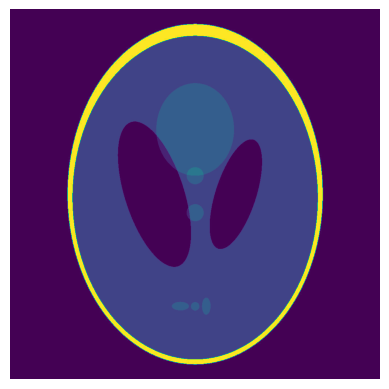

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import color
import numpy as np

from PIL import Image

examples_dir='example-data/'
filename='Shepp_logan.jpg'
image = mpimg.imread(examples_dir + filename)
if len(image.shape) == 3:
    image = np.mean(image, axis=2)  # ?????? bez tego nie działa radon ale to koloruje obrazek

plt.imshow(image)
plt.axis('off')
plt.show()

In [21]:
def bresenham_algorithm(x0, y0, x1, y1):
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while True:
        points.append((x0, y0))  
        if x0 == x1 and y0 == y1:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

    return points

In [ ]:
def radon_transform(image, step, detectors_num, span): #kolejno: krok (alfa we wzorach), liczba detektorów i rozpiętość/rozwartość układu (kąt fi we wzorach)
    step = step*np.pi/180 #stopnie->radiany
    span = span*np.pi/180

    sinogram = np.zeros((int(2 * np.pi / step), detectors_num))
    x_center = image.shape[0]/2
    y_center = image.shape[1]/2
    radius = np.sqrt((x_center)**2+(y_center)**2) #ramię emitera liczone od środka obrazka x, y
    
    angles = [i * step for i in range(int(2 * np.pi / step))]
    indices = [int(i) for i in range(int(2*np.pi/step))]

    for idx, angle in zip(indices, angles):
        emitter_pos = [int(x_center + radius * np.cos(angle)), int(y_center + radius * np.sin(angle))]

        detector_first_pos = angle + np.pi - span/2
        detector_last_pos = angle + np.pi +span/2
        det_angles = np.arange(detector_first_pos, detector_last_pos, span/detectors_num)
        for det_idx, det_angle in zip(range(detectors_num), det_angles):
            #ruch detektora
            det_pos = [int(x_center + radius * np.cos(det_angle)), int(y_center + radius * np.sin(det_angle))]
            #pkt na linii det-emit -> bresenham
            points = list(bresenham_algorithm(emitter_pos[0], emitter_pos[1], det_pos[0], det_pos[1]))
            bright_points = 0
            sum_bright = 0.0
            for point in points:
                if 0 <= point[0] < image.shape[0] and 0 <= point[1] < image.shape[1]:
                    bright_points +=1
                    sum_bright += float(image[point[0]][point[1]])
            if bright_points>0: #jak są pkt to dajemy w sinogram
                sinogram[idx][det_idx] = sum_bright/bright_points
            else:
                sinogram[idx][det_idx] = 0

    sinogram_scaled = (255.0 / np.amax(sinogram)) * sinogram
    sinogram_scaled = sinogram_scaled.astype(np.uint8)
    sinogram_image = Image.fromarray(sinogram_scaled.T, mode='L')
    sinogram_resized = sinogram_image.resize((image.shape[1], image.shape[0]), resample=Image.NEAREST)
    sinogram_resized.save('sinogram.png')


In [26]:
radon_transform(image, 1, 180, 180)